## Packages

In [401]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

colors = ['#008080', '#FF6961']


## Data Import

In [402]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
# variable information 
cdc_diabetes_health_indicators.variables


,name,role,type,demographic,description,units,missing_values
0,ID,ID,Integer,None,Patient ID,None,no
1,Diabetes_binary,Target,Binary,None,0 = no diabetes 1 = prediabetes or diabetes,None,no
2,HighBP,Feature,Binary,None,0 = no high BP 1 = high BP,None,no
3,HighChol,Feature,Binary,None,0 = no high cholesterol 1 = high cholesterol,None,no
4,CholCheck,Feature,Binary,None,0 = no cholesterol check in 5 years 1 = yes ch...,None,no
5,BMI,Feature,Integer,None,Body Mass Index,None,no
6,Smoker,Feature,Binary,None,Have you smoked at least 100 cigarettes in you...,None,no
7,Stroke,Feature,Binary,None,(Ever told) you had a stroke. 0 = no 1 = yes,None,no
8,HeartDiseaseorAttack,Feature,Binary,None,coronary heart disease (CHD) or myocardial inf...,None,no
9,PhysActivity,Feature,Binary,None,physical activity in past 30 days - not includ...,None,no


In [403]:
# metadata 
metadata = cdc_diabetes_health_indicators.metadata
metadata = pd.DataFrame(list(metadata.items()), columns=['Metadata', 'Description'])
metadata

,Metadata,Description
0,uci_id,891
1,name,CDC Diabetes Health Indicators
2,repository_url,https://archive.ics.uci.edu/dataset/891/cdc+di...
3,data_url,https://archive.ics.uci.edu/static/public/891/...
4,abstract,The Diabetes Health Indicators Dataset contain...
5,area,Health and Medicine
6,tasks,[Classification]
7,characteristics,"[Tabular, Multivariate]"
8,num_instances,253680
9,num_features,21


In [404]:
# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features #Features
Y = cdc_diabetes_health_indicators.data.targets #Target Variable

diabetes_data = pd.concat([X, Y], axis=1)
diabetes_data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


## Exploratory Data Analysis (EDA)

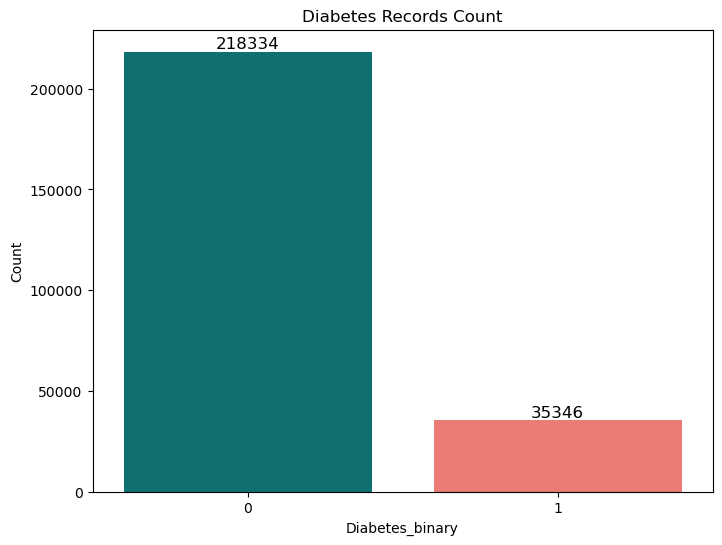

In [405]:
d = pd.DataFrame(diabetes_data['Diabetes_binary'].value_counts())
d = d.reset_index().rename(columns={'index': 'Diabetes_binary'})

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Diabetes_binary', y='count', data=d, palette=['#008080', '#FF6961'])
for i, (diab, count) in enumerate(zip(d['Diabetes_binary'], d['count'])):
    barplot.text(i, count + 0.2, f'{count:.0f}', ha='center', va='bottom', fontsize=12, color='black')
plt.title('Diabetes Records Count')
plt.xlabel('Diabetes_binary')
plt.ylabel('Count')
plt.show()

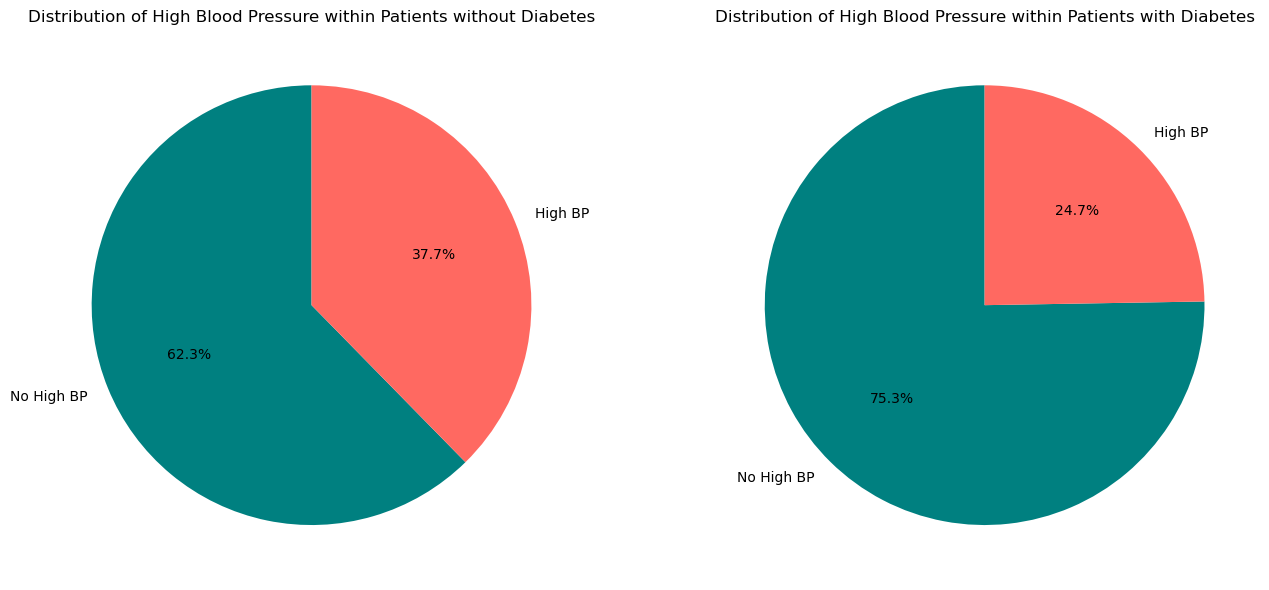

In [406]:
df_no_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 0]
df_yes_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 1]

no_db_counts = df_no_diabetes['HighBP'].value_counts(normalize=True) * 100
yes_db_counts = df_yes_diabetes['HighBP'].value_counts(normalize=True) * 100

no_labels = ['No High BP' if i % 2 == 0 else 'High BP' for i in range(len(no_db_counts))]
yes_labels = ['No High BP' if i % 2 == 0 else 'High BP' for i in range(len(yes_db_counts))]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(no_db_counts, labels=no_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Distribution of High Blood Pressure within Patients without Diabetes')

axes[1].pie(yes_db_counts, labels=yes_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Distribution of High Blood Pressure within Patients with Diabetes')

plt.tight_layout()
plt.show()

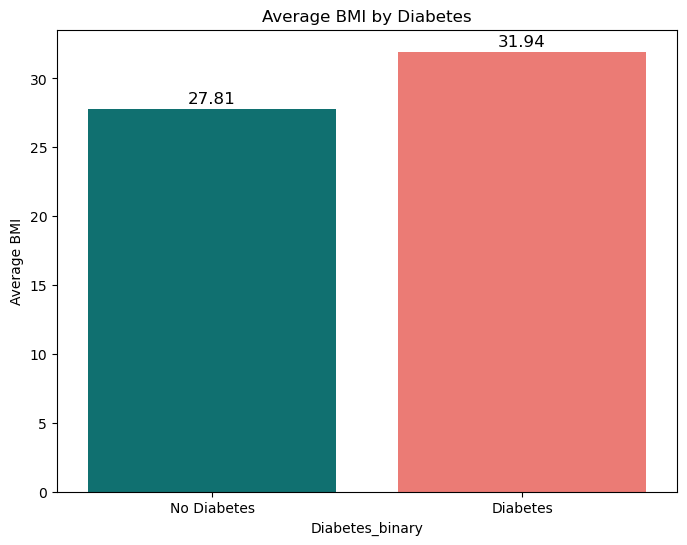

In [407]:
average_bmi = diabetes_data.groupby('Diabetes_binary')['BMI'].mean().reset_index()
diabetes_labels = {0: 'No Diabetes', 1: 'Diabetes'}
average_bmi['Diabetes_binary'] = average_bmi['Diabetes_binary'].map(diabetes_labels)

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Diabetes_binary', y='BMI', data=average_bmi, palette=['#008080', '#FF6961'])
for i, (diab, bmi) in enumerate(zip(average_bmi['Diabetes_binary'], average_bmi['BMI'])):
    barplot.text(i, bmi + 0.2, f'{bmi:.2f}', ha='center', va='bottom', fontsize=12, color='black')
plt.title('Average BMI by Diabetes')
plt.xlabel('Diabetes_binary')
plt.ylabel('Average BMI')
plt.show()

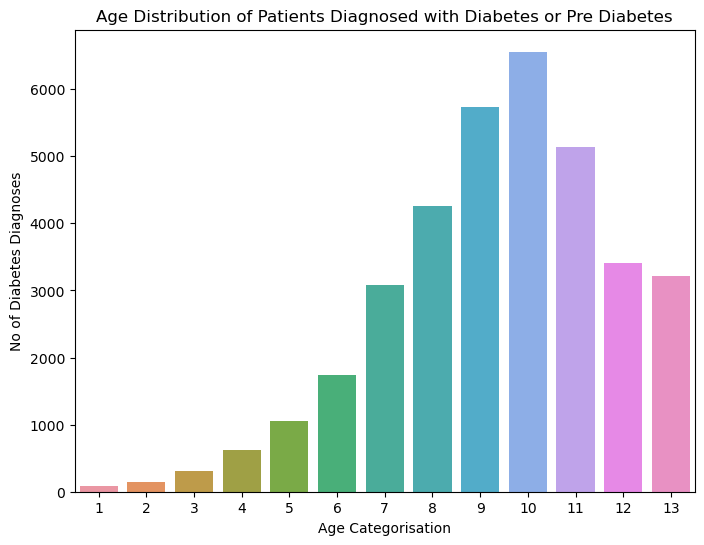

In [408]:
age_dist_with_diabetes = df_yes_diabetes.groupby('Age')['Diabetes_binary'].count().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Age', y='Diabetes_binary', data=age_dist_with_diabetes)
plt.title('Age Distribution of Patients Diagnosed with Diabetes or Pre Diabetes')
plt.xlabel('Age Categorisation')
plt.ylabel('No of Diabetes Diagnoses')
plt.show()

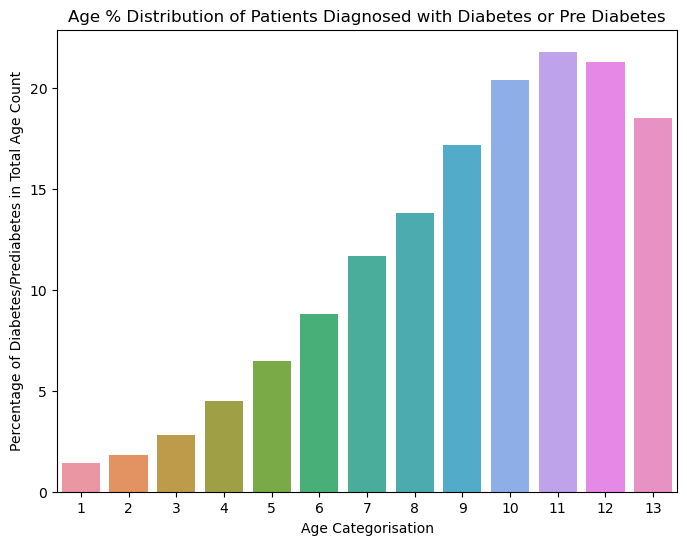

In [409]:
age_dist = diabetes_data.groupby('Age')['Diabetes_binary'].count().reset_index()

age_merged = pd.merge(age_dist_with_diabetes, age_dist[['Age', 'Diabetes_binary']], on='Age')

age_merged['AgeProportion'] = (age_merged['Diabetes_binary_x'] / age_merged['Diabetes_binary_y']) * 100
age_merged['AgeProportion'] = age_merged['AgeProportion'].round(1) 

plt.figure(figsize=(8, 6))
sns.barplot(x='Age', y='AgeProportion', data=age_merged)
plt.title('Age % Distribution of Patients Diagnosed with Diabetes or Pre Diabetes')
plt.xlabel('Age Categorisation')
plt.ylabel('Percentage of Diabetes/Prediabetes in Total Age Count')
plt.show()


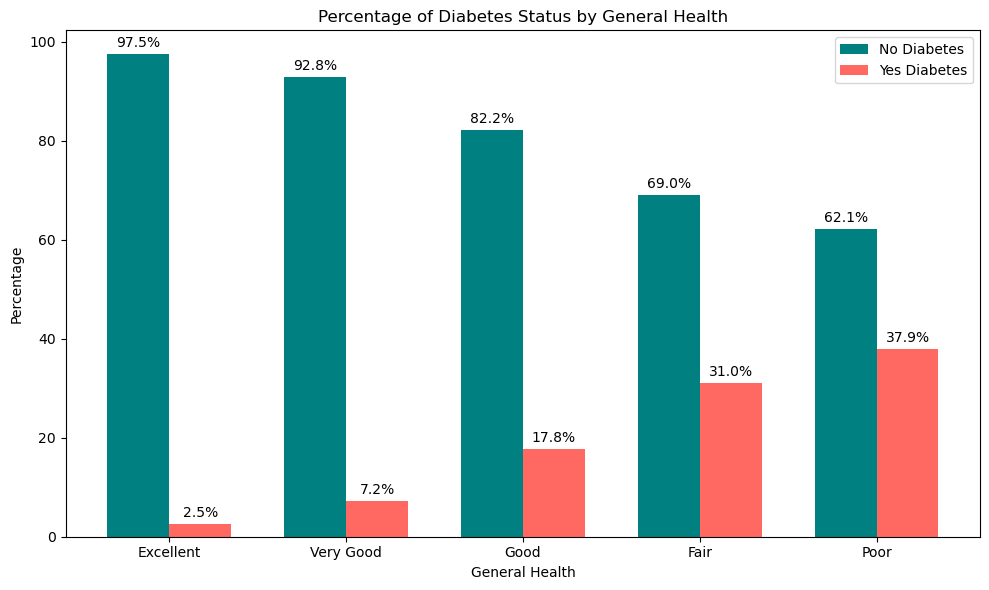

In [410]:
# Count frequencies of each combination of GenHlth and diabetes
count_data = diabetes_data.groupby(['GenHlth', 'Diabetes_binary']).size().unstack(fill_value=0)

# Calculate percentage of each diabetes status for each GenHlth category
count_data['Total'] = count_data.sum(axis=1)
count_data['No_percentage'] = (count_data[0] / count_data['Total']) * 100
count_data['Yes_percentage'] = (count_data[1] / count_data['Total']) * 100

labels =['Excellent', 'Very Good', 'Good', 'Fair', 'Poor']
ind = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(ind - width/2, count_data['No_percentage'], width, label='No Diabetes', color=colors[0])
rects2 = ax.bar(ind + width/2, count_data['Yes_percentage'], width, label='Yes Diabetes', color=colors[1])

ax.set_xlabel('General Health')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Diabetes Status by General Health')
ax.set_xticks(ind)
ax.set_xticklabels(labels)
ax.legend()

def add_labels(rects, percentages):
    for rect, percentage in zip(rects, percentages):
        height = rect.get_height()
        ax.annotate('{:.1f}%'.format(percentage),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1, count_data['No_percentage'])
add_labels(rects2, count_data['Yes_percentage'])

plt.tight_layout()
plt.show()


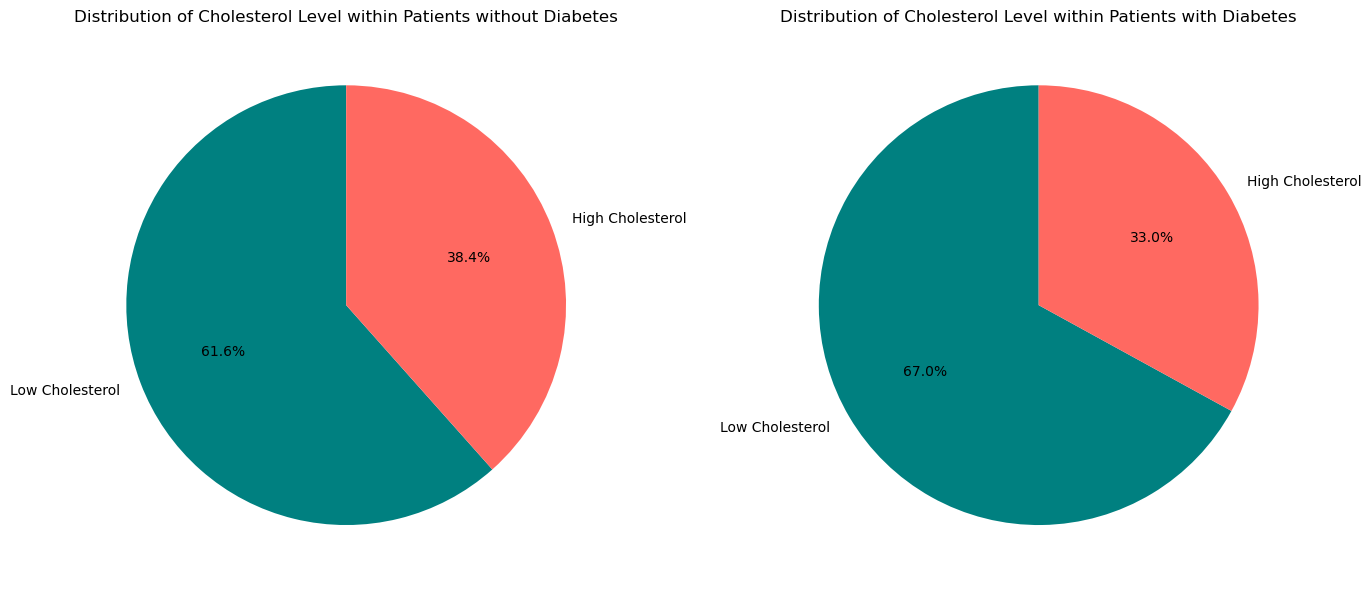

In [411]:
df_no_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 0]
df_yes_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 1]

no_db_counts = df_no_diabetes['HighChol'].value_counts(normalize=True) * 100
yes_db_counts = df_yes_diabetes['HighChol'].value_counts(normalize=True) * 100

no_labels = ['Low Cholesterol' if i % 2 == 0 else 'High Cholesterol' for i in range(len(no_db_counts))]
yes_labels = ['Low Cholesterol' if i % 2 == 0 else 'High Cholesterol' for i in range(len(yes_db_counts))]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(no_db_counts, labels=no_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Distribution of Cholesterol Level within Patients without Diabetes')

axes[1].pie(yes_db_counts, labels=yes_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Distribution of Cholesterol Level within Patients with Diabetes')

plt.tight_layout()
plt.show()

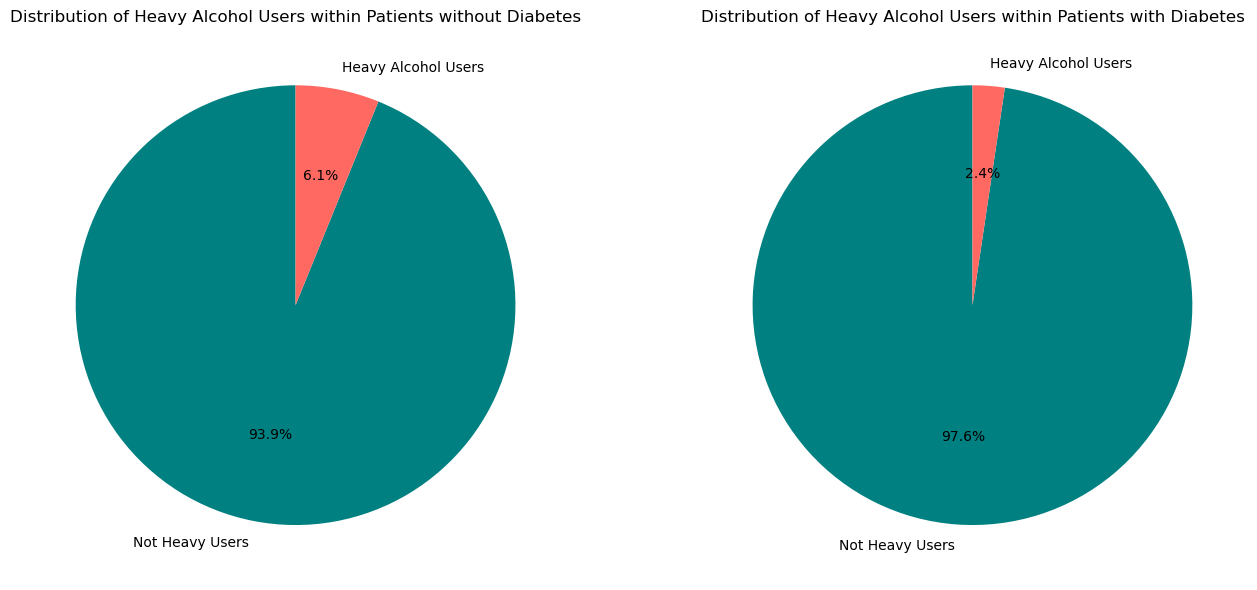

In [412]:
df_no_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 0]
df_yes_diabetes = diabetes_data[diabetes_data['Diabetes_binary'] == 1]

no_db_counts = df_no_diabetes['HvyAlcoholConsump'].value_counts(normalize=True) * 100
yes_db_counts = df_yes_diabetes['HvyAlcoholConsump'].value_counts(normalize=True) * 100

no_labels = ['Not Heavy Users' if i % 2 == 0 else 'Heavy Alcohol Users' for i in range(len(no_db_counts))]
yes_labels = ['Not Heavy Users' if i % 2 == 0 else 'Heavy Alcohol Users' for i in range(len(yes_db_counts))]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(no_db_counts, labels=no_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Distribution of Heavy Alcohol Users within Patients without Diabetes')

axes[1].pie(yes_db_counts, labels=yes_labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Distribution of Heavy Alcohol Users within Patients with Diabetes')

plt.tight_layout()
plt.show()

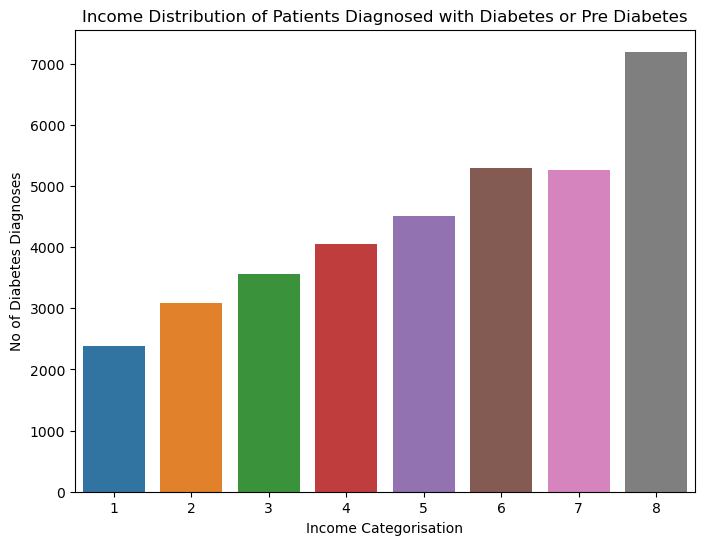

In [414]:
income_dist_with_diabetes = df_yes_diabetes.groupby('Income')['Diabetes_binary'].count().reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(x='Income', y='Diabetes_binary', data=income_dist_with_diabetes)
plt.title('Income Distribution of Patients Diagnosed with Diabetes or Pre Diabetes')
plt.xlabel('Income Categorisation')
plt.ylabel('No of Diabetes Diagnoses')
plt.show()

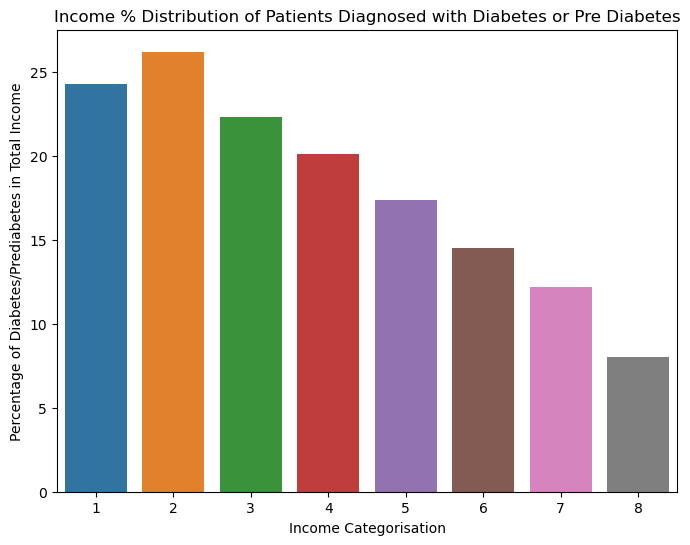

In [415]:
income_dist = diabetes_data.groupby('Income')['Diabetes_binary'].count().reset_index()

income_merged = pd.merge(income_dist_with_diabetes, income_dist[['Income', 'Diabetes_binary']], on='Income')

income_merged['IncomeProportion'] = (income_merged['Diabetes_binary_x'] / income_merged['Diabetes_binary_y']) * 100
income_merged['IncomeProportion'] = income_merged['IncomeProportion'].round(1) 

plt.figure(figsize=(8, 6))
sns.barplot(x='Income', y='IncomeProportion', data=income_merged)
plt.title('Income % Distribution of Patients Diagnosed with Diabetes or Pre Diabetes')
plt.xlabel('Income Categorisation')
plt.ylabel('Percentage of Diabetes/Prediabetes in Total Income')
plt.show()

## Data Preprocessing

In [233]:
# Split dataset into training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state= 14)

In [234]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

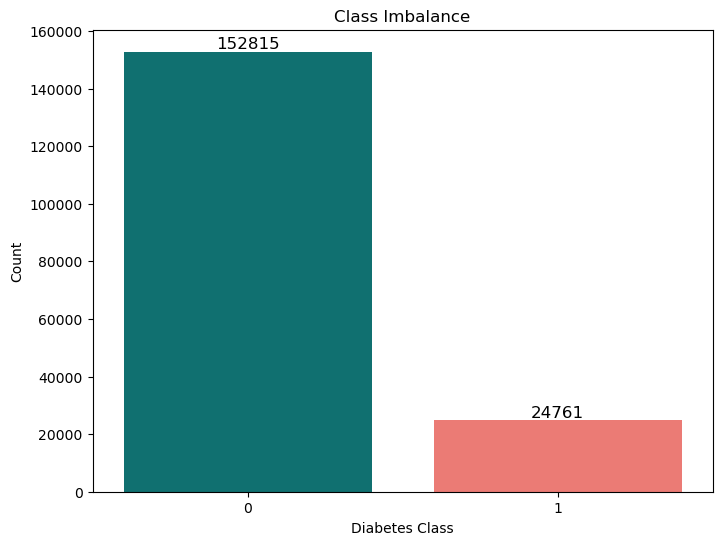

In [418]:
# Investigate Class Imbalance
e = pd.DataFrame(Y_train.value_counts())
e = e.reset_index().rename(columns={'index': 'Diabetes_binary'})

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Diabetes_binary', y='count', data=e, palette=['#008080', '#FF6961'])
for i, (diab, count) in enumerate(zip(e['Diabetes_binary'], e['count'])):
    barplot.text(i, count + 0.2, f'{count:.0f}', ha='center', va='bottom', fontsize=12, color='black')
plt.title('Class Imbalance')
plt.xlabel('Diabetes Class')
plt.ylabel('Count')
plt.show()

In [236]:
# Address class imbalance with smote over sampling.
resampler = SMOTE(random_state = 45)
X_train_sm, Y_train_sm = resampler.fit_resample(X_train_sc, Y_train)
Y_train_sm.value_counts()

Diabetes_binary
0                  152815
1                  152815
Name: count, dtype: int64

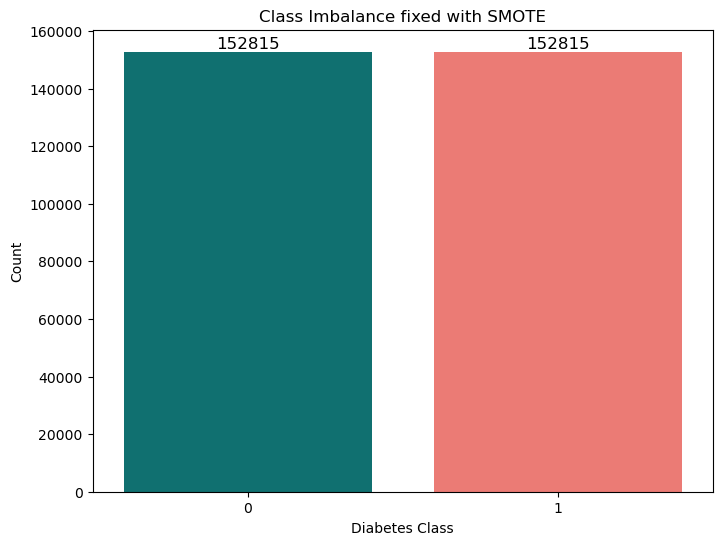

In [420]:
f = pd.DataFrame(Y_train_sm.value_counts())
f = f.reset_index().rename(columns={'index': 'Diabetes_binary'})

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Diabetes_binary', y='count', data=f, palette=['#008080', '#FF6961'])
for i, (diab, count) in enumerate(zip(f['Diabetes_binary'], f['count'])):
    barplot.text(i, count + 0.2, f'{count:.0f}', ha='center', va='bottom', fontsize=12, color='black')
plt.title('Class Imbalance fixed with SMOTE')
plt.xlabel('Diabetes Class')
plt.ylabel('Count')
plt.show()

## Training

### Decision Trees Algorithm

In [433]:
# Hyperparameter Tuning
# Initialize the model
dt = DecisionTreeClassifier()

# Define the parameter grid
param_grid_dt = {
    'max_depth': [20, 50],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [2, 4]
}

# Initialize GridSearchCV
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data
grid_search_dt.fit(X_train_sm, Y_train_sm)
best_params_dt = grid_search_dt.best_params_
print(f"Best Paramters for Decision Trees Hyperparamter Tuning: {best_params_dt}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5; total time=   4.9s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5; total time=   5.0s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=10; total time=   5.1s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=20; total time=   2.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=5; total time=   2.7s
[CV] END max_depth=20, min_samples_leaf=4, min_samples_split=10; total time=   2.7s
[CV] END max_depth=

In [434]:
dt_classifier = DecisionTreeClassifier(
    criterion = 'gini', 
    max_depth=20,
    min_samples_leaf= 4,
    min_samples_split=20,
    random_state = 10,
)

dt_classifier.fit(X_train_sm, Y_train_sm)

DecisionTreeClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=20,
                       random_state=10)

In [435]:
print(f"\nDecision Tree model Training Accuracy: {dt_classifier.score(X_train_sm, Y_train_sm):0.2f}")
dt_acc = round(dt_classifier.score(X_test_sc, Y_test),2)
print(f"\nDecision Tree Test Accuracy: {dt_acc}")


Decision Tree model Training Accuracy: 0.91

Decision Tree Test Accuracy: 0.83


In [436]:
Y_pred_dtc = dt_classifier.predict(X_test_sc)
Y_prob_dtc = dt_classifier.predict_proba(X_test_sc)[:, 1]
dt_roc = round(roc_auc_score(Y_test, Y_prob_dtc),2)
print(f"\nROC Score: {dt_roc}")


ROC Score: 0.76


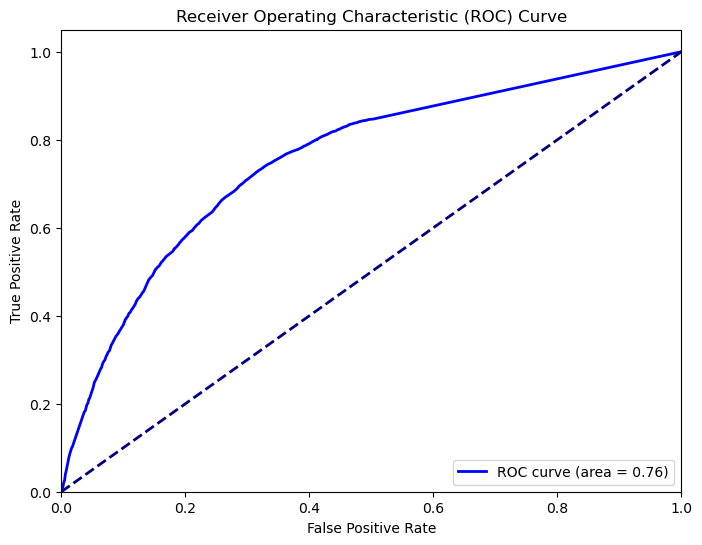

In [437]:
roc_curve(Y_test, Y_pred_dtc)

# Compute the ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_dtc)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Decision Trees')
plt.legend(loc="lower right")
plt.show()

In [438]:
dt_report = classification_report(Y_test,Y_pred_dtc)
print(dt_report)
report_lines = dt_report.split('\n')
dt_f1_score_class_1 = round(float(report_lines[3].split()[3]),2)

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     65519
           1       0.39      0.36      0.37     10585

    accuracy                           0.83     76104
   macro avg       0.64      0.63      0.64     76104
weighted avg       0.83      0.83      0.83     76104



In [439]:
confusion_matrix_dtc = confusion_matrix(Y_test,Y_pred_dtc)  
print(pd.DataFrame(confusion_matrix_dtc))

       0     1
0  59487  6032
1   6760  3825


<Axes: title={'center': 'Feature Importance Chart for Decision Trees'}>

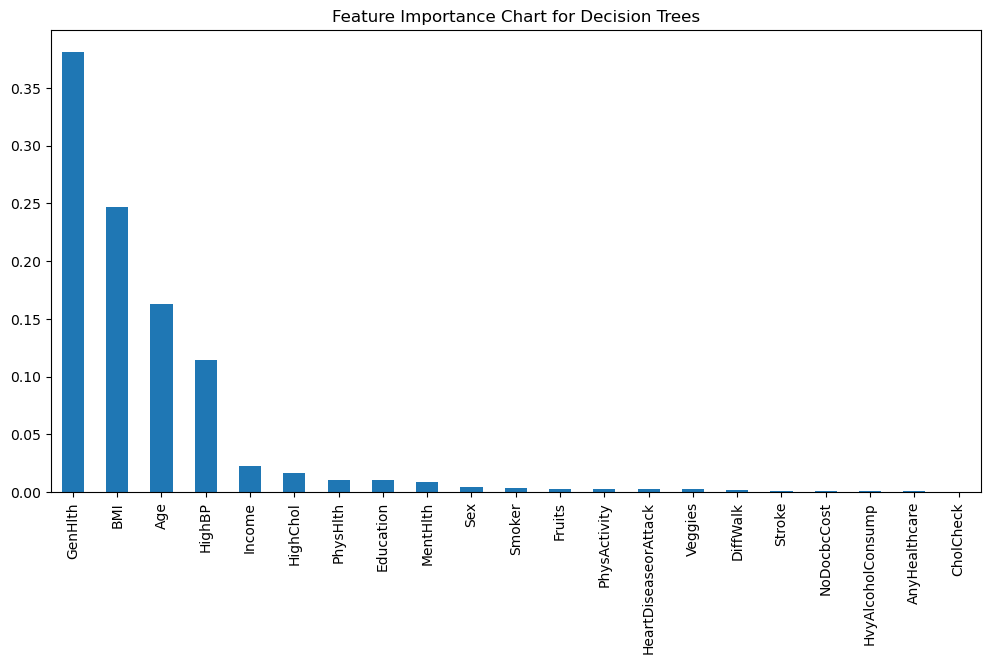

In [440]:
dt_importances = pd.Series(dt_classifier.feature_importances_, index=X.columns)
plt.figure(figsize=(12,6))
plt.title('Feature Importance Chart for Decision Trees')
dt_importances.sort_values(ascending=False).plot.bar()

### Random Forest

In [441]:
# Hyperparameter Tuning
# Initialize the model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 40],
    'min_samples_leaf': [2,10]
}

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search to the data
grid_search_rf.fit(X_train_sm, Y_train_sm)
best_params_rf = grid_search_rf.best_params_
print(f"Best Paramters for Random Forest Hyperparamter Tuning: {best_params_rf}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector 

[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  52.9s
[CV] END max_depth=10, min_samples_leaf=10, n_estimators=100; total time=  52.9s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  53.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=10, n_estimators=100; total time=  55.6s
[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=100; total time=  55.7s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time= 2.0min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time= 2.0min
[CV] END max_depth=10, min_samples_leaf=10, n_estimators=100; total time= 1.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=10, min_samples_leaf=2, n_estimators=200; total time= 2.1min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=100; total time= 1.9min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=10, n_estimators=200; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=10, n_estimators=200; total time= 2.2min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=10, min_samples_leaf=10, n_estimators=200; total time= 2.3min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=100; total time= 1.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=100; total time= 1.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=40, min_samples_leaf=10, n_estimators=100; total time= 1.4min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=40, min_samples_leaf=10, n_estimators=100; total time= 1.4min
[CV] END max_depth=40, min_samples_leaf=10, n_estimators=100; total time= 1.5min
[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=200; total time= 3.2min
[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=200; total time= 3.1min
[CV] END .max_depth=40, min_samples_leaf=2, n_estimators=200; total time= 2.8min
[CV] END max_depth=40, min_samples_leaf=10, n_estimators=200; total time= 2.2min
[CV] END max_depth=40, min_samples_leaf=10, n_estimators=200; total time= 2.3min
[CV] END max_depth=40, min_samples_leaf=10, n_estimators=200; total time= 1.6min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best Paramters for Random Forest Hyperparamter Tuning: {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 200}


In [442]:
rfc = RandomForestClassifier (
              random_state=42,
              max_depth=40,
              n_estimators=200,
              min_samples_leaf = 2,
              min_samples_split = 2
            )

rfc.fit(X_train_sm, Y_train_sm)

/var/folders/4x/2_5z_g113cx4vljkhhvqdvt40000gn/T/ipykernel_25447/624583750.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train_sm, Y_train_sm)


RandomForestClassifier(min_samples_leaf=2, n_estimators=200, random_state=42)

In [443]:
print(f"\nDecision Tree model Training Accuracy: {rfc.score(X_train_sm, Y_train_sm):0.2f}")
rf_acc = round(rfc.score(X_test_sc, Y_test),2)
print(f"\nDecision Tree Test Accuracy: {rf_acc}")


Decision Tree model Training Accuracy: 0.97

Decision Tree Test Accuracy: 0.85


In [444]:
Y_pred_rfc = rfc.predict(X_test_sc)
Y_prob_rfc = rfc.predict_proba(X_test_sc)[:, 1]
rf_roc = round(roc_auc_score(Y_test, Y_prob_rfc),2)
print(f"\nROC Score: {rf_roc}")


ROC Score: 0.82


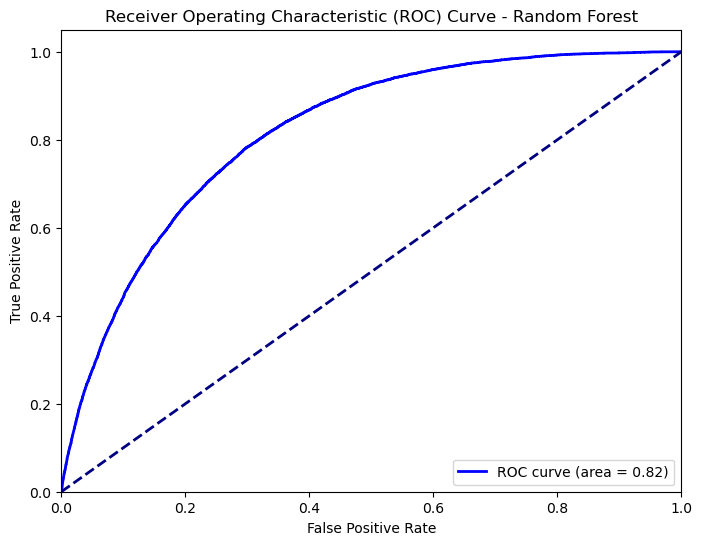

In [445]:
roc_curve(Y_test, Y_pred_rfc)

# Compute the ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_rfc)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

In [446]:
rf_report = classification_report(Y_test,Y_pred_rfc)
print(rf_report)
report_lines = rf_report.split('\n')
rf_f1_score_class_1 = round(float(report_lines[3].split()[3]),2)

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     65519
           1       0.46      0.32      0.37     10585

    accuracy                           0.85     76104
   macro avg       0.68      0.63      0.65     76104
weighted avg       0.83      0.85      0.84     76104



In [447]:
confusion_matrix_rfc = confusion_matrix(Y_test,Y_pred_rfc)  
print(pd.DataFrame(confusion_matrix_rfc))

       0     1
0  61555  3964
1   7235  3350


<Axes: title={'center': 'Feature Importance Chart for Random Forest'}>

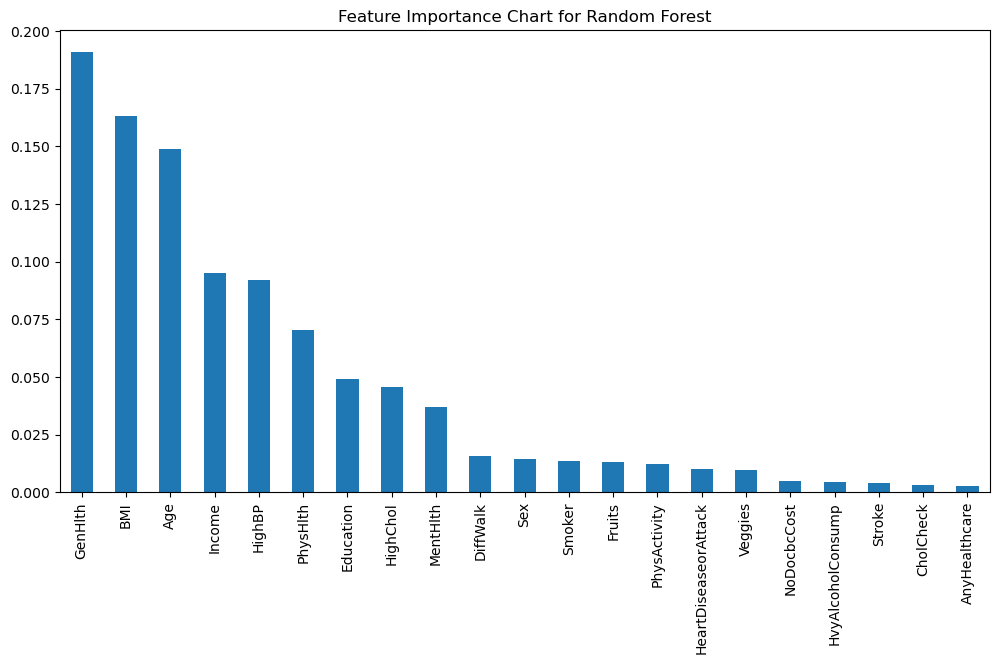

In [448]:
rf_importances = pd.Series(rfc.feature_importances_, index=X.columns)
plt.figure(figsize=(12,6))
plt.title('Feature Importance Chart for Random Forest')
rf_importances.sort_values(ascending=False).plot.bar()

### XGBoost

In [449]:
# Hyperparameter Tuning
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # Objective for binary classification
    eval_metric='logloss'
)

param_grid_xg = {
    'max_depth': [2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 200, 300]
}

grid_search_xg = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xg,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search_xg.fit(X_train_sm, Y_train_sm)
best_params_xg = grid_search_xg.best_params_
print(f"Best Paramters for XGBoost Hyperparamter Tuning: {best_params_xg}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   4.9s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=100; total time=   5.0s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=300; total time=  10.6s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   8.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   8.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=200; total time=   8.3s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=300; total time=  12.2s
[CV] END ..learning_rate=0.01, max_depth=2, n_estimators=300; total time=  12.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   8.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   8.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_es

In [450]:
xg_model = XGBClassifier(
    n_estimators=100,       
    max_depth=10,     
    learning_rate=0.1,    
    objective='binary:logistic', 
    eval_metric='logloss', 
)

xg_model.fit(X_train_sm, Y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [451]:
print(f"\nXGBoost Training Accuracy: {xg_model.score(X_train_sm, Y_train_sm):0.2f}")
xg_acc = round(xg_model.score(X_test_sc, Y_test),2)
print(f"\nXGBoost Test Accuracy: {xg_acc}")


XGBoost Training Accuracy: 0.92

XGBoost Test Accuracy: 0.86


In [452]:
Y_pred_xg = xg_model.predict(X_test_sc)
Y_prob_xg = xg_model.predict_proba(X_test_sc)[:, 1]
xg_roc = round(roc_auc_score(Y_test, Y_prob_xg),2)
print(f"\nROC Score: {xg_roc}")


ROC Score: 0.82


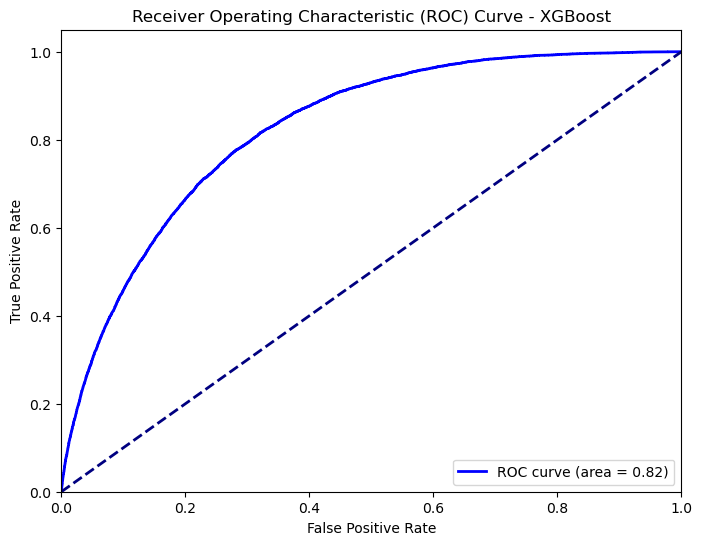

In [453]:
roc_curve(Y_test, Y_prob_xg)

# Compute the ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_xg)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

In [454]:
xg_report = classification_report(Y_test,Y_pred_xg)
print(xg_report)
report_lines = xg_report.split('\n')
xg_f1_score_class_1 = round(float(report_lines[3].split()[3]),2)

              precision    recall  f1-score   support

           0       0.89      0.97      0.92     65519
           1       0.53      0.23      0.32     10585

    accuracy                           0.86     76104
   macro avg       0.71      0.60      0.62     76104
weighted avg       0.84      0.86      0.84     76104



In [455]:
confusion_matrix_xg = confusion_matrix(Y_test,Y_pred_xg)  
print(pd.DataFrame(confusion_matrix_xg))

       0     1
0  63400  2119
1   8196  2389


<Axes: title={'center': 'Feature Importance Chart for XGBoost'}>

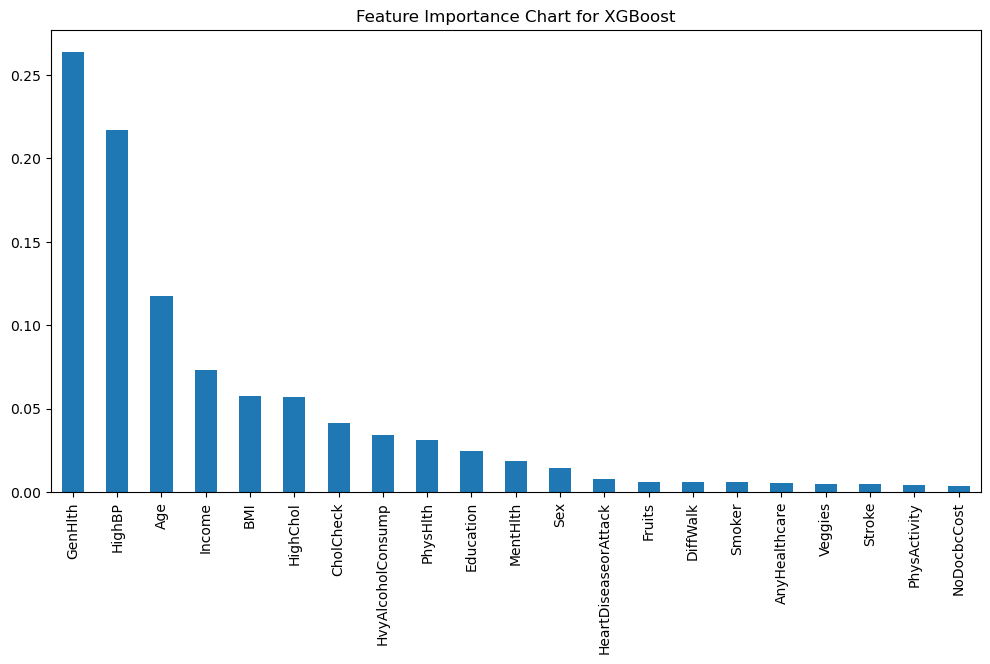

In [456]:
xg_importances = pd.Series(xg_model.feature_importances_, index=X.columns)
plt.figure(figsize=(12,6))
plt.title('Feature Importance Chart for XGBoost')
xg_importances.sort_values(ascending=False).plot.bar()

### Logistic Regression

In [457]:
# Hyperparameter Tuning
lr_clf = LogisticRegression(
    penalty ='l2',
    solver= 'lbfgs',
)

param_grid_lr = {
    'C': np.logspace(-4,4,4),
    'max_iter': [100, 10000]
}

grid_search_lr = GridSearchCV(
    estimator=lr_clf,
    param_grid=param_grid_lr,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search_lr.fit(X_train_sm, Y_train_sm)
best_params_lr = grid_search_lr.best_params_
print(f"Best Paramters for Logistic Regression Hyperparamter Tuning: {best_params_lr}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END .............................C=0.0001, max_iter=100; total time=   1.0s
[CV] END .............................C=0.0001, max_iter=100; total time=   1.1s
[CV] END .............................C=0.0001, max_iter=100; total time=   1.1s
[CV] END ...........................C=0.0001, max_iter=10000; total time=   1.1s
[CV] END ...........................C=0.0001, max_iter=10000; total time=   1.2s
[CV] END ...........................C=0.0001, max_iter=10000; total time=   1.2s
[CV] END ...............C=0.046415888336127774, max_iter=100; total time=   1.3s
[CV] END ...............C=0.046415888336127774, max_iter=100; total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END ..................C=21.54434690031882, max_iter=100; total time=   1.2s
[CV] END ..................C=21.54434690031882, max_iter=100; total time=   1.3s
[CV] END ...............C=0.046415888336127774, max_iter=100; total time=   1.4s
[CV] END .............C=0.046415888336127774, max_iter=10000; total time=   1.4s
[CV] END .............C=0.046415888336127774, max_iter=10000; total time=   1.4s
[CV] END ..................C=21.54434690031882, max_iter=100; total time=   1.4s
[CV] END .............C=0.046415888336127774, max_iter=10000; total time=   1.4s
[CV] END ................C=21.54434690031882, max_iter=10000; total time=   1.0s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

[CV] END ..........................C=10000.0, max_iter=10000; total time=   1.4s
[CV] END ..........................C=10000.0, max_iter=10000; total time=   1.4s
[CV] END ............................C=10000.0, max_iter=100; total time=   1.5s
[CV] END ................C=21.54434690031882, max_iter=10000; total time=   1.5s
[CV] END ............................C=10000.0, max_iter=100; total time=   1.5s
[CV] END ............................C=10000.0, max_iter=100; total time=   1.5s
[CV] END ................C=21.54434690031882, max_iter=10000; total time=   1.5s
[CV] END ..........................C=10000.0, max_iter=10000; total time=   1.5s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Paramters for Logistic Regression Hyperparamter Tuning: {'C': 0.046415888336127774, 'max_iter': 100}


In [460]:
lr_model = LogisticRegression(
    penalty='l2',
    C=0.046415888336127774,
    solver= 'lbfgs',
    max_iter= 100 
)
lr_model.fit(X_train_sm, Y_train_sm)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.046415888336127774)

In [462]:
print(f"\nDecision Tree model Training Accuracy: {lr_model.score(X_train_sm, Y_train_sm):0.2f}")
lr_acc = round(lr_model.score(X_test_sc, Y_test),2)
print(f"\nDecision Tree Test Accuracy: {lr_acc}")


Decision Tree model Training Accuracy: 0.75

Decision Tree Test Accuracy: 0.73


In [463]:
Y_pred_lr = lr_model.predict(X_test_sc)
Y_prob_lr = lr_model.predict_proba(X_test_sc)[:, 1]
lr_roc = round(roc_auc_score(Y_test, Y_prob_lr),2)
print(f"\nROC Score: {lr_roc}")


ROC Score: 0.82


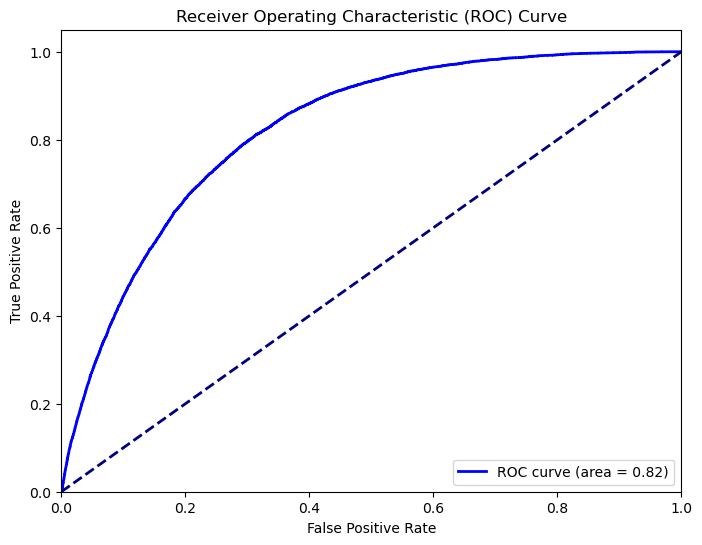

In [464]:
roc_curve(Y_test, Y_prob_lr)

# Compute the ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob_lr)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [465]:
lr_report = classification_report(Y_test,Y_pred_lr)
print(lr_report)
report_lines = lr_report.split('\n')
lr_f1_score_class_1 = round(float(report_lines[3].split()[3]),2)

              precision    recall  f1-score   support

           0       0.95      0.73      0.83     65519
           1       0.31      0.76      0.44     10585

    accuracy                           0.73     76104
   macro avg       0.63      0.75      0.63     76104
weighted avg       0.86      0.73      0.77     76104



In [466]:
confusion_matrix_lr = confusion_matrix(Y_test,Y_pred_lr)  
print(pd.DataFrame(confusion_matrix_lr))

       0      1
0  47784  17735
1   2516   8069


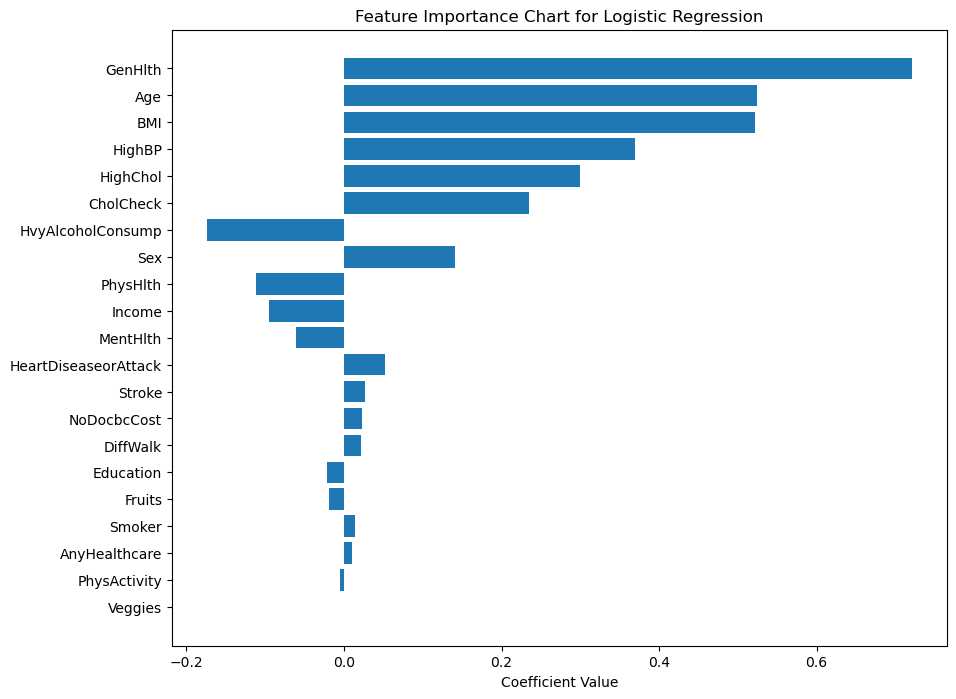

In [467]:
# Logistics Regression doesn't have inherently provided feature imlortance scores as the other tree based methods do. HSo the feature impoortance is interpreted by examining the mahinitude of the models coeeficients, Larger absolute values indicate more important features.

lr_importances = lr_model.coef_[0]
column_headers = X.columns.values

importance_df = pd.DataFrame({'Feature': column_headers,'Importance': lr_importances})
importance_df = importance_df.sort_values(by='Importance', key=abs, ascending=False)

plt.figure(figsize=(10,8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance Chart for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

# Algorithm Comparative Analysis

In [470]:
algorithm_comparison_obj = {
    'Metrics': ['Accuracy', 'ROC Score', 'F1 Score for Diabetes Class'],
    'Decision Trees': [dt_acc, dt_roc, dt_f1_score_class_1],
    'Random Forest': [rf_acc, rf_roc, rf_f1_score_class_1],
    'XGBoost': [xg_acc, xg_roc, xg_f1_score_class_1],
    'Logistic Regression': [lr_acc, lr_roc, lr_f1_score_class_1]
}


# Create DataFrame
algorithm_comparison = pd.DataFrame(algorithm_comparison_obj)

# Display the DataFrame
algorithm_comparison

,Metrics,Decision Trees,Random Forest,XGBoost,Logistic Regression
0,Accuracy,0.83,0.85,0.86,0.73
1,ROC Score,0.76,0.82,0.82,0.82
2,F1 Score for Diabetes Class,0.37,0.37,0.32,0.44
